Sujana Shahrin   ID-2220836


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Standard libs
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# PyTorch / torchvision for model & training
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models

# Utilities for evaluation & plotting
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)
import seaborn as sns

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Show plots inline (Colab)
%matplotlib inline

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
!cp -r "/content/drive/MyDrive/Dataset/Processed_2D_dataset_split" "/content/"


In [ ]:
# Dataset folder paths (you provided)
train_root = "/content/Processed_2D_dataset_split/Train_Prewitt_filter"
val_root   = "/content/Processed_2D_dataset_split/Val"
test_root  = "/content/Processed_2D_dataset_split/Test"

# Quick sanity check
for p in [train_root, val_root, test_root]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Path not found: {p}")
print("Paths exist. Good to proceed.")


Paths exist. Good to proceed.


In [ ]:
# Dataset class (slice-level)
# Scans patient folders under each split folder
# Derives slice label from mask (if mask exists and has any nonzero pixel - 1)
# Returns (image_tensor, label)
from PIL import Image

IMG_SIZE = 224  # ResNet standard input size

# Transforms:
# Resize to 224x224
# Convert to tensor and normalize
# Repeat grayscale to 3 channels so we can use pretrained ResNet weights unchanged
train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ToTensor(),                 # gives 1xHxW for grayscale
    T.Normalize([0.5], [0.5]),    # normalize single channel
    T.Lambda(lambda x: x.repeat(3,1,1))  # convert 1-3 channels
])

eval_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5]),
    T.Lambda(lambda x: x.repeat(3,1,1))
])

class SliceDataset(Dataset):
    def __init__(self, split_root, transform=None):
        self.split_root = split_root
        self.transform = transform
        self.samples = []  # list of tuples (img_path, label)

        # Walk patient folders
        patients = sorted(os.listdir(split_root))
        for pid in patients:
            pdir = os.path.join(split_root, pid)
            if not os.path.isdir(pdir):
                continue
            mri_dir = os.path.join(pdir, "MRI")
            mask_dir = os.path.join(pdir, "MASK")
            if not os.path.isdir(mri_dir):
                continue

            # collect all image files in MRI folder
            for fname in sorted(os.listdir(mri_dir)):
                if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
                    continue
                img_path = os.path.join(mri_dir, fname)
                # corresponding mask path; if missing we'll assume label 0
                mask_path = os.path.join(mask_dir, fname)
                label = 0
                if os.path.exists(mask_path):
                    # quick check: if any pixel > 0 => positive slice
                    try:
                        m = Image.open(mask_path).convert('L')
                        arr = np.array(m)
                        if arr.sum() > 0:
                            label = 1
                    except Exception:
                        # if mask can't be read, keep label 0
                        label = 0
                self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('L')  # always load as grayscale
        if self.transform:
            img_t = self.transform(img)           # tensor (3,H,W) because of repeat
        else:
            img_t = T.ToTensor()(img).repeat(3,1,1)
        return img_t, torch.tensor(label, dtype=torch.float32)


In [ ]:
import glob

print("Train image count:", len(glob.glob(train_root + "/**/*.png", recursive=True)))
print("Val image count:",   len(glob.glob(val_root   + "/**/*.png", recursive=True)))
print("Test image count:",  len(glob.glob(test_root  + "/**/*.png", recursive=True)))


Train image count: 4527
Val image count: 1312
Test image count: 1933


In [ ]:
from torchvision import set_image_backend
set_image_backend("accimage")


# Create Datasets and DataLoaders
BATCH_SIZE = 16
NUM_WORKERS = 4

train_ds = SliceDataset(train_root, transform=train_transform)
val_ds   = SliceDataset(val_root,   transform=eval_transform)
test_ds  = SliceDataset(test_root,  transform=eval_transform)

print("Number of slices -> Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)


Number of slices -> Train: 2271 Val: 656 Test: 974


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Build model (ResNet‑50 pretrained)

# Load ResNet-50 with pretrained weights
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
# Replace final fully connected layer to output single logit
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Print model summary of last layer to confirm change
print(model.fc)


Linear(in_features=2048, out_features=1, bias=True)


In [ ]:
# Loss, optimizer, scheduler, helper functions
criterion = nn.BCEWithLogitsLoss()  # stable for single-logit binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

def logits_to_preds_and_probs(logits):
    probs = torch.sigmoid(logits).detach().cpu().numpy()
    preds = (probs > 0.5).astype(int)
    return probs, preds


In [ ]:
# Training loop (with validation), saving best model
# Records train/val loss and accuracy for plotting
EPOCHS = 50
best_val_loss = float('inf')
save_path = "/content/drive/MyDrive/Dataset/resnet50_best_slice.pth"  # change if you want

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, EPOCHS+1):
    # ---- TRAIN ----
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_samples = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs).squeeze(1)           # shape (B,)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        probs, preds = logits_to_preds_and_probs(logits)
        running_correct += (preds == labels.detach().cpu().numpy()).sum()
        running_samples += imgs.size(0)

    epoch_train_loss = running_loss / running_samples
    epoch_train_acc = running_correct / running_samples
    train_losses.append(epoch_train_loss); train_accs.append(epoch_train_acc)

    # ---- VALIDATION ----
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    val_running_samples = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device); labels = labels.to(device)
            logits = model(imgs).squeeze(1)
            loss = criterion(logits, labels)

            val_running_loss += loss.item() * imgs.size(0)
            probs, preds = logits_to_preds_and_probs(logits)
            val_running_correct += (preds == labels.detach().cpu().numpy()).sum()
            val_running_samples += imgs.size(0)

    epoch_val_loss = val_running_loss / val_running_samples if val_running_samples>0 else 0.0
    epoch_val_acc = val_running_correct / val_running_samples if val_running_samples>0 else 0.0
    val_losses.append(epoch_val_loss); val_accs.append(epoch_val_acc)

    # LR scheduler step (ReduceLROnPlateau expects a scalar val metric)
    scheduler.step(epoch_val_loss)

    # Save best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss
        }, save_path)
        print(f"Saved best model (val_loss {best_val_loss:.4f}) to: {save_path}")

    print(f"Epoch {epoch}/{EPOCHS} | Train loss: {epoch_train_loss:.4f} acc: {epoch_train_acc:.4f} | "
          f"Val loss: {epoch_val_loss:.4f} acc: {epoch_val_acc:.4f}")


Saved best model (val_loss 0.5293) to: /content/drive/MyDrive/Dataset/resnet50_best_slice.pth
Epoch 1/50 | Train loss: 0.4589 acc: 0.7627 | Val loss: 0.5293 acc: 0.7820
Epoch 2/50 | Train loss: 0.3484 acc: 0.8353 | Val loss: 0.5525 acc: 0.8034
Epoch 3/50 | Train loss: 0.2745 acc: 0.8939 | Val loss: 0.5302 acc: 0.7896
Epoch 4/50 | Train loss: 0.2106 acc: 0.9124 | Val loss: 0.7990 acc: 0.6723
Epoch 5/50 | Train loss: 0.1886 acc: 0.9335 | Val loss: 0.5727 acc: 0.7805
Epoch 6/50 | Train loss: 0.1437 acc: 0.9441 | Val loss: 0.5434 acc: 0.7790
Saved best model (val_loss 0.4620) to: /content/drive/MyDrive/Dataset/resnet50_best_slice.pth
Epoch 7/50 | Train loss: 0.1108 acc: 0.9577 | Val loss: 0.4620 acc: 0.8216
Epoch 8/50 | Train loss: 0.0933 acc: 0.9657 | Val loss: 0.5429 acc: 0.8064
Epoch 9/50 | Train loss: 0.0798 acc: 0.9727 | Val loss: 0.5085 acc: 0.8262
Epoch 10/50 | Train loss: 0.0760 acc: 0.9714 | Val loss: 0.5594 acc: 0.8232
Epoch 11/50 | Train loss: 0.0658 acc: 0.9784 | Val loss: 0.61

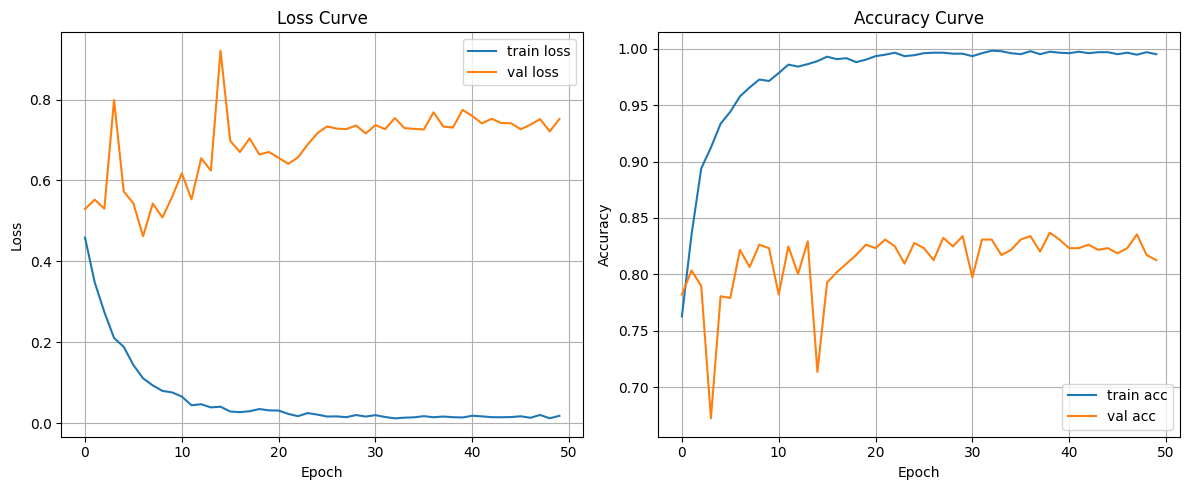

In [ ]:

# Plot training curves (loss and accuracy)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve"); plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(train_accs, label="train acc")
plt.plot(val_accs, label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curve"); plt.legend(); plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
# Load best model (for test evaluation)
# load saved checkpoint
ckpt = torch.load(save_path, map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
print("Loaded best model from epoch", ckpt.get('epoch', '?'), "val_loss", ckpt.get('val_loss', '?'))
model.eval()


Loaded best model from epoch 7 val_loss 0.46195409356093986


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Test evaluation (slice-level) and collect preds/probs
all_probs = []
all_preds = []
all_trues = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs).squeeze(1)
        probs, preds = logits_to_preds_and_probs(logits)

        all_probs.extend(probs.tolist())
        all_preds.extend(preds.tolist())
        all_trues.extend(labels.numpy().astype(int).tolist())

# convert to numpy arrays for sklearn functions
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_trues = np.array(all_trues)

print("Test samples:", len(all_trues))


Test samples: 974


=== Test metrics (slice-level) ===
Accuracy  : 0.8121
Precision : 0.5654
Recall    : 0.5735
F1-score  : 0.5694


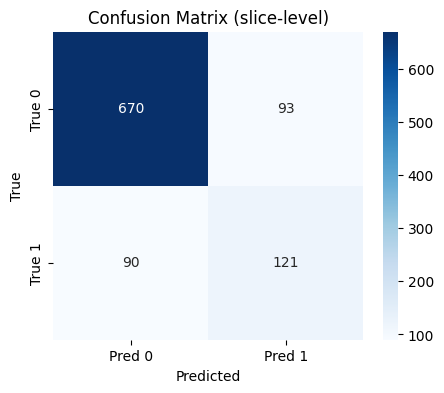

In [ ]:
# Metrics block (accuracy, precision, recall, F1 only)
# + Confusion Matrix plot

# Compute standard metrics (use zero_division=0 to avoid errors)
acc = accuracy_score(all_trues, all_preds)
prec = precision_score(all_trues, all_preds, zero_division=0)
rec = recall_score(all_trues, all_preds, zero_division=0)
f1 = f1_score(all_trues, all_preds, zero_division=0)

# Print summary metrics
print("=== Test metrics (slice-level) ===")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(all_trues, all_preds)

# Plot confusion matrix with seaborn
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (slice-level)')
plt.show()


In [ ]:
# Save slice-level predictions CSV

import pandas as pd

test_image_paths = [s[0] for s in test_ds.samples]  # test_ds.samples keeps order
# If DataLoader shuffled was False, order should match; ensure lengths match
if len(test_image_paths) != len(all_trues):
    print("Warning: mismatch between collected predictions and dataset samples; skipping save.")
else:
    out_df = pd.DataFrame({
        'image_path': test_image_paths,
        'true': all_trues,
        'pred': all_preds,
        'prob': all_probs
    })
    out_csv = os.path.join("/content/drive/MyDrive/Dataset", "test_slice_predictions.csv")
    out_df.to_csv(out_csv, index=False)
    print("Saved test predictions to:", out_csv)


Saved test predictions to: /content/drive/MyDrive/Dataset/test_slice_predictions.csv
